In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report




In [6]:
df = pd.read_csv(r'D:\AICTE INTERNSHIP 1\metadata.csv')  # Replace with actual dataset path

# Debugging: Print column names to verify 'outbreak' exists
print("Dataset Columns:", df.columns)



Dataset Columns: Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')


In [7]:
print("Available Columns After Preprocessing:", df.columns)


Available Columns After Preprocessing: Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')


In [8]:
if 'RT_PCR_positive' not in df.columns:
    raise KeyError("Column 'RT_PCR_positive' not found in dataset. Check your CSV file.")

# Data Preprocessing
# Fill missing numerical values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill missing categorical values with the most frequent value
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical variables if any, except 'RT_PCR_positive'
categorical_cols = [col for col in categorical_cols if col != 'RT_PCR_positive']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Ensure 'RT_PCR_positive' still exists after encoding
if 'RT_PCR_positive' not in df.columns:
    raise KeyError("Column 'RT_PCR_positive' was removed during preprocessing. Check categorical encoding.")

# Verify no NaN values remain
if df.isnull().sum().sum() > 0:
    raise ValueError("Dataset still contains NaN values after preprocessing. Check missing data handling.")


In [9]:
X = df.drop(columns=['RT_PCR_positive'])  # Ensure 'RT_PCR_positive' is the target column
y = df['RT_PCR_positive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluate Model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.9315789473684211
              precision    recall  f1-score   support

     Unclear       1.00      0.73      0.84        48
           Y       0.92      1.00      0.96       142

    accuracy                           0.93       190
   macro avg       0.96      0.86      0.90       190
weighted avg       0.94      0.93      0.93       190



In [10]:
print(df.columns)


Index(['offset', 'age', 'RT_PCR_positive', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count',
       'patientid_100', 'patientid_101',
       ...
       'other_notes_Credit to Zhe Xu *, Lei Shi *, Yijin Wang *, Jiyuan Zhang, Lei Huang, Chao Zhang, Shuhong Liu, Peng Zhao, Hongxia Liu, Li Zhu, Yanhong Tai, Changqing Bai, Tingting Gao, Jinwen Song, Peng Xia, Jinghui Dong , Jingmin Zhao, Fu-Sheng Wang',
       'other_notes_Image originally shared on Figure 1.',
       'other_notes_Since January 2020 Elsevier has created a COVID-19 resource centre with free information in English and Mandarin on the novel coronavirus COVID-19. The COVID-19 resource centre is hosted on Elsevier Connect, the company's public news and information website. Elsevier hereby grants permission to make all its COVID-19-related research that is available on the COVID-19 resource centre - including this research content - immediately available in PubMed Central and other

In [11]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [12]:
# Debugging: Print missing values before raising an error
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("Columns with missing values:\n", missing_values[missing_values > 0])
    raise ValueError("Dataset still contains NaN values after preprocessing.")


In [13]:
X = df.drop(columns=['RT_PCR_positive'])  # Ensure 'RT_PCR_positive' is the target column
y = df['RT_PCR_positive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


In [15]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.9421052631578948
              precision    recall  f1-score   support

     Unclear       1.00      0.77      0.87        48
           Y       0.93      1.00      0.96       142

    accuracy                           0.94       190
   macro avg       0.96      0.89      0.92       190
weighted avg       0.95      0.94      0.94       190



In [16]:
time_steps = 30  # Using last 30 days data for prediction

# Adjust dataset size to be a multiple of time_steps
adjusted_size = (len(df) // time_steps) * time_steps
df = df.iloc[:adjusted_size]

X_lstm = df[['lymphocyte_count', 'age', 'temperature', 'leukocyte_count']].values
X_lstm = X_lstm.reshape((len(X_lstm) // time_steps, time_steps, 4))
y_lstm = df['RT_PCR_positive'].values.reshape((len(df) // time_steps, time_steps, 1))

# Split into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Simple Moving Average Model for Time-Series Prediction
predictions = np.mean(X_test_lstm, axis=1)[:, -1]

In [17]:
y_test_lstm_flat = y_test_lstm[:, -1].flatten()
predictions_flat = predictions.flatten()


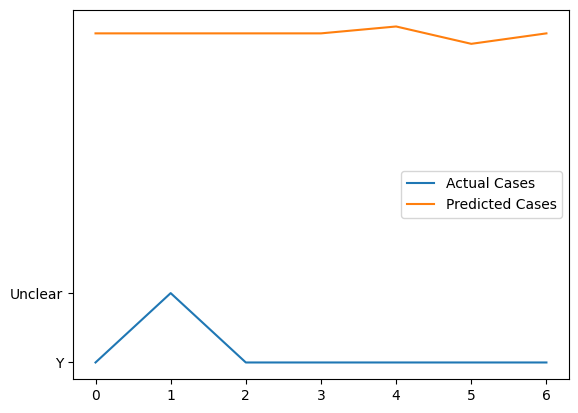

In [18]:
# Plot Actual vs Predicted Cases
plt.plot(y_test_lstm_flat, label='Actual Cases')
plt.plot(predictions_flat, label='Predicted Cases')
plt.legend()
plt.show()
